In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import random

from transformers import PretrainedConfig
from model.visual_token_embedding import VisualTokenEmbedding
from utils.visualization import visualize_masks

import json
from visual_tokenizer import get_visual_tokenizer
from data import get_dataset


/home/dchenbs/anaconda3/envs/subobjects_vlm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# dataset = get_dataset('imagenet', '/share/datasets/imagenet', split='train')
# dataset = get_dataset('coco', '/share/datasets/coco2017', split='train')
# dataset = get_dataset('clevr_caption', '/home/dchenbs/workspace/datasets/CLEVR_v1.0', split='train')
# dataset = get_dataset('image_paragraph_captioning', '/home/dchenbs/workspace/datasets/VisualGenome', split='train')

# datset = get_dataset('sharegpt4v', '/home/dchenbs/workspace/datasets/sharegpt4v/ShareGPT4V/sharegpt4v_mix665k_cap23k_coco-ap9k_lcs3k_sam9k_div2k.json', split='train')
# dataset = get_dataset('sharegpt4v', '/home/dchenbs/workspace/datasets/sharegpt4v/ShareGPT4V/share-captioner_coco_lcs_sam_1246k_1107.json', split='train')
dataset = get_dataset('sharegpt4v', '/home/dchenbs/workspace/datasets/sharegpt4v/ShareGPT4V/sharegpt4v_instruct_gpt4-vision_cap100k.json', split='train')

Total samples: 102025, using train split: 81620 (from 0 to 81620)
Total samples: 102025, after removing text-only samples: 81620


In [3]:
image_resolution = 1024
max_tokens = 32

config = json.load(open('configs/visual_tokenizer/directsam_tiny.json'))

visual_tokenizer = get_visual_tokenizer(**config, image_resolution=image_resolution, max_tokens=max_tokens)

In [4]:
config = json.load(open('configs/visual_embedding/rgb_pixel.json'))
# config = json.load(open('configs/visual_embedding/vae.json'))
# config = json.load(open('configs/visual_embedding/convnext_in22k_stage2.json'))

visual_token_embedding_config = PretrainedConfig.from_dict(config)
visual_token_embedding_config.image_resolution = image_resolution


# visual_token_embedding_config = PretrainedConfig.from_dict({
#     "image_resolution": image_resolution,
#     "token_resolution": 16,

#     # "vision_encoder_type": "rgb_pixel",
#     # # "vision_encoder_name": "rgb_pixel",
    
#     # "vision_encoder_type": "diffusers_vae",
#     # "vision_encoder_name": "chendelong/stable-diffusion-3-medium-vae",

#     # # https://huggingface.co/models?sort=trending&search=facebook%2Fdinov2
#     # "vision_encoder_type": "hf_autobacbone",
#     # "vision_encoder_name": "facebook/dinov2-giant", # small, base, large, giant
    
#     # # # https://huggingface.co/models?search=facebook/convnextv2
#     "vision_encoder_type": "hf_autobacbone",
#     "vision_encoder_name": "facebook/convnextv2-tiny-22k-384/stage3", 

#     # # https://huggingface.co/models?search=microsoft/resnet
#     # "vision_encoder_type": "hf_autobacbone",
#     # "vision_encoder_name": "microsoft/resnet-50", # 18, 34, 50, 101

#     # https://huggingface.co/timm
#     # "vision_encoder_type": "timm_backbone",
#     # "vision_encoder_name": "convnext_large_mlp.clip_laion2b_soup_ft_in12k_in1k_320/-2", 
# })


visual_token_embedding = VisualTokenEmbedding(visual_token_embedding_config).cuda()

print(visual_token_embedding.device, visual_token_embedding.dtype)

print(visual_token_embedding.vision_encoder.feature_channels, 'channels')

cuda torch.float32
3 channels


In [5]:
n_samples = 2

images = []
for i in range(n_samples):
    image = dataset[random.randint(0, len(dataset) - 1)]['image']
    images.append(image)

feature_maps = visual_token_embedding.vision_encoder(images)
print(feature_maps.shape, feature_maps.dtype, feature_maps.device)
feature_maps = feature_maps.cpu().numpy()

feature_resolution = feature_maps.shape[-1]

torch.Size([2, 3, 1024, 1024]) torch.float32 cuda:0


In [6]:
from sklearn.decomposition import PCA
import numpy as np

def apply_pca(feature_maps):
    # do PCA on the channel dimension
    # feature_maps: N, C, H, W
    N, C, H, W = feature_maps.shape
    if C>3:
        feature_vectors = feature_maps.swapaxes(0, 1).reshape(C, -1).T

        pca = PCA(n_components=3)
        feature_vectors = pca.fit_transform(feature_vectors)
        feature_maps = feature_vectors.T.reshape(3, N, H, W).swapaxes(0, 1)

    # N, 3, H, W -> N, H, W, 3
    feature_maps = feature_maps.swapaxes(1, 3).swapaxes(1, 2)
    feature_maps = (feature_maps - np.min(feature_maps)) / (np.max(feature_maps) - np.min(feature_maps))
    return feature_maps

feature_maps_rgb = apply_pca(feature_maps)

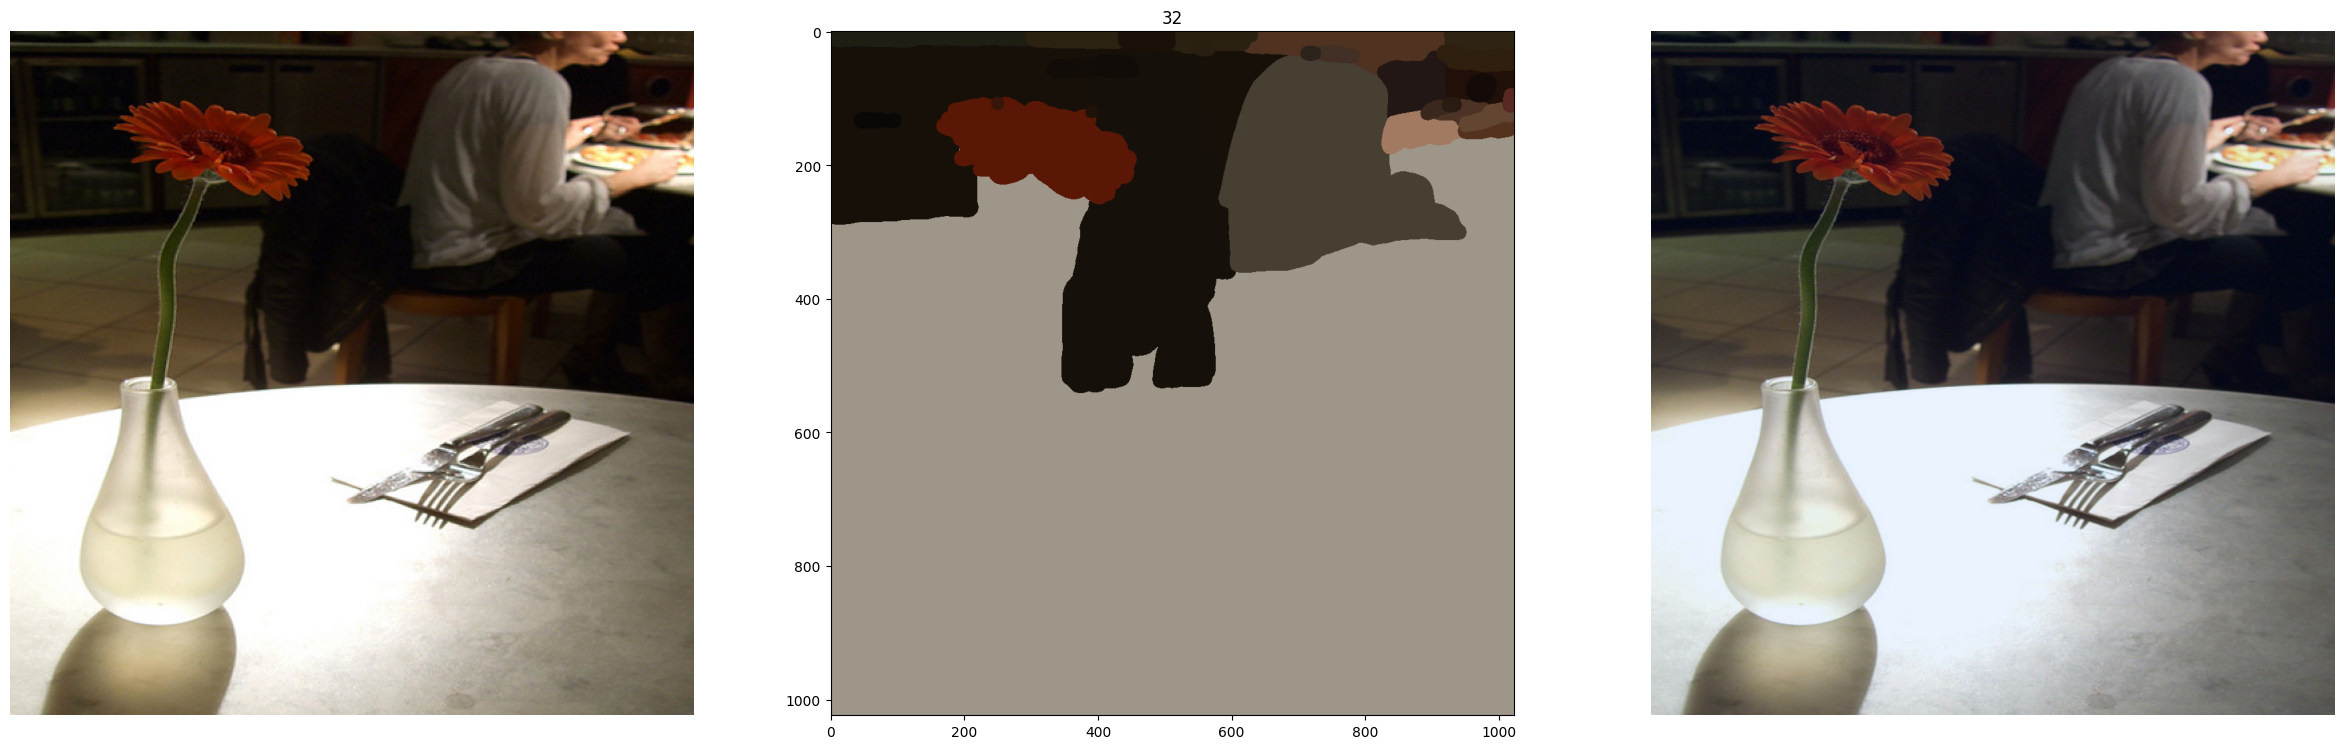

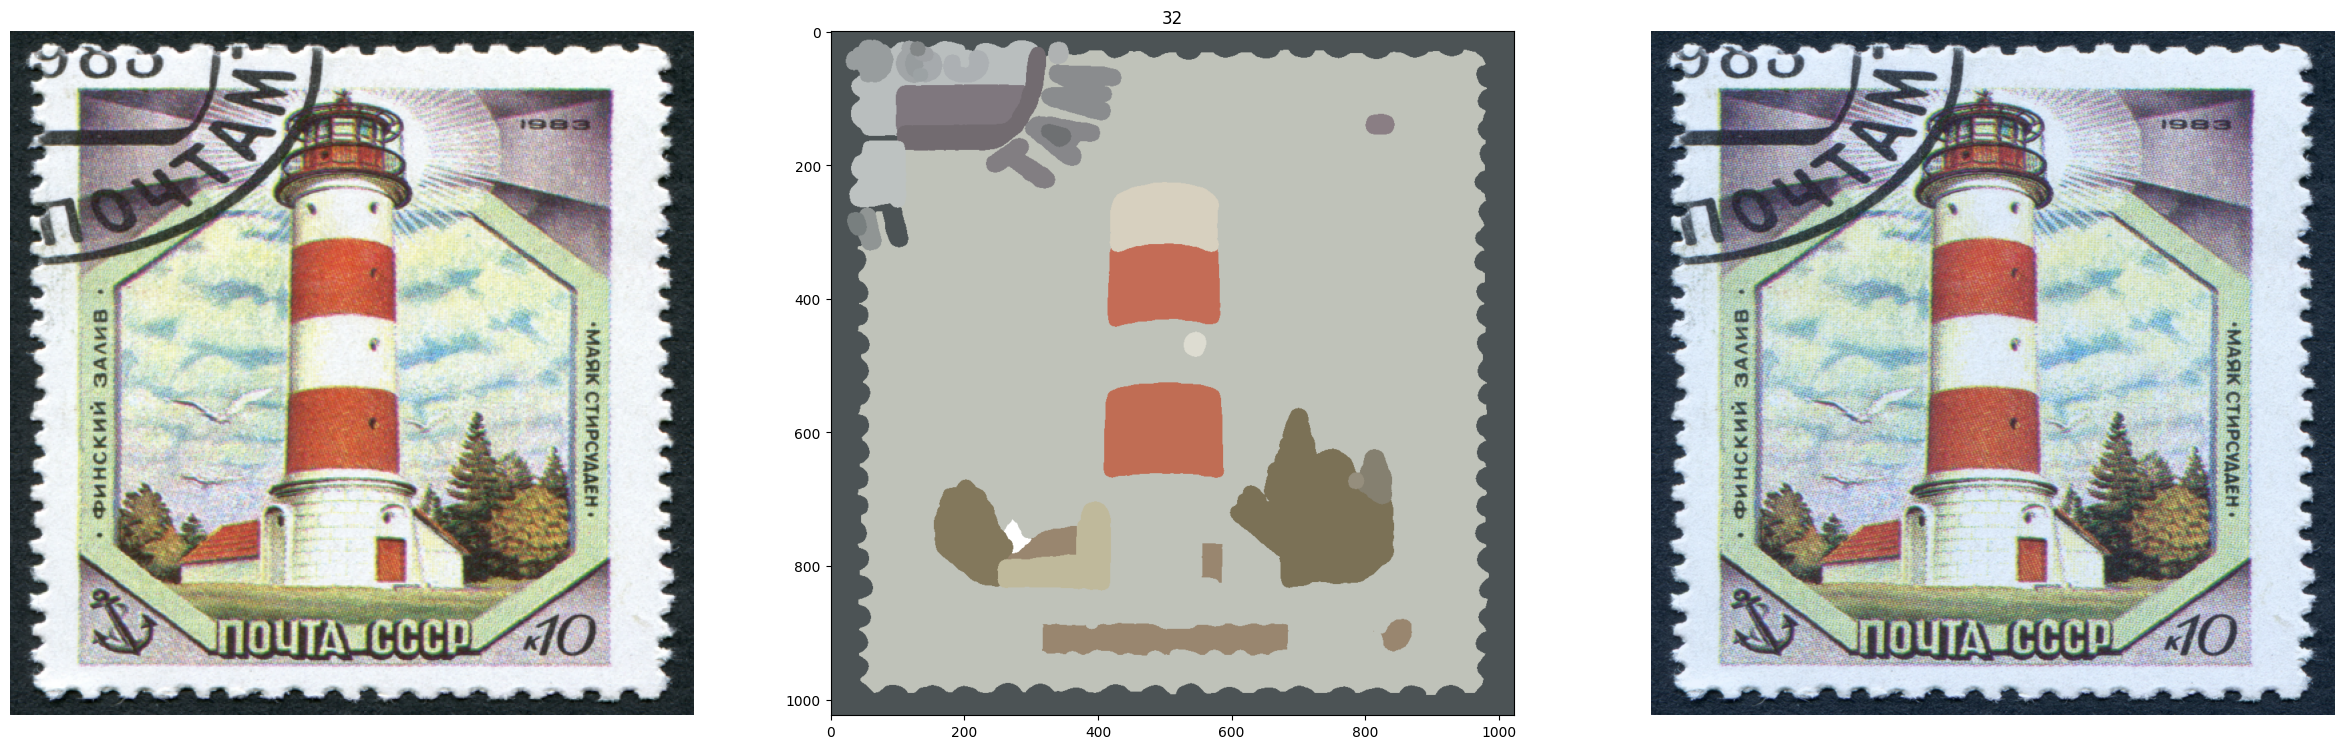

In [7]:
import matplotlib.pyplot as plt
batch_masks = visual_tokenizer(images)
batch_masks_cpu = batch_masks.cpu().numpy()

for b, image in enumerate(images):
    image = image.resize((image_resolution, image_resolution))
    plt.figure(figsize=(30, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(image.resize((512, 512)))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(visualize_masks(image, batch_masks_cpu[b][:64]))
    plt.title(len(batch_masks_cpu[0]))

    plt.subplot(1, 3, 3)
    plt.imshow(feature_maps_rgb[b])
    plt.axis("off")

    plt.show()

In [8]:
roi_boxes, roi_masks, embeddings = visual_token_embedding(images, batch_masks)
print('embeddings', embeddings.shape)
print('roi_boxes', roi_boxes.shape)
print('roi_masks', roi_masks.shape)

roi_boxes = roi_boxes.cpu().numpy()
embeddings = embeddings.cpu().numpy()
roi_masks = roi_masks.cpu().numpy()

embeddings = (embeddings - np.min(embeddings)) / (np.max(embeddings) - np.min(embeddings))

embeddings torch.Size([2, 32, 12288])
roi_boxes torch.Size([2, 32, 4])
roi_masks torch.Size([2, 32, 64, 64])


<Figure size 1500x1500 with 0 Axes>

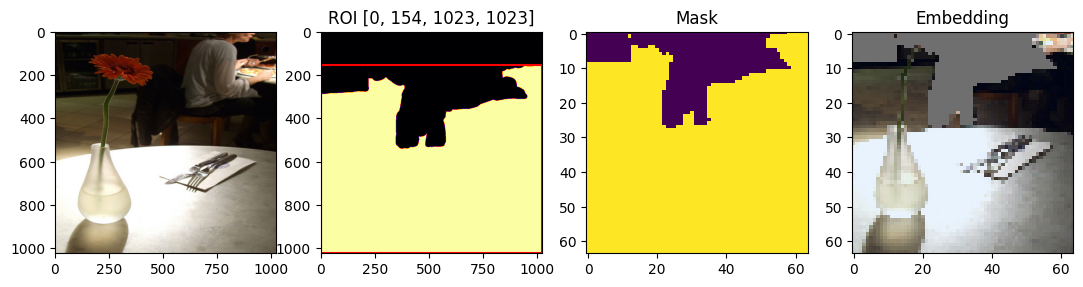

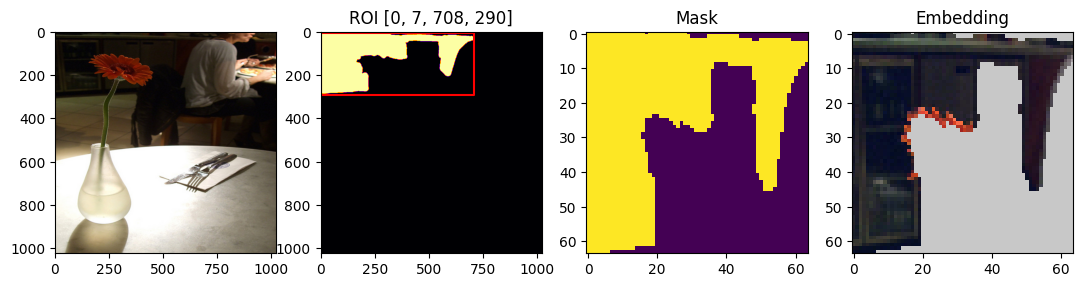

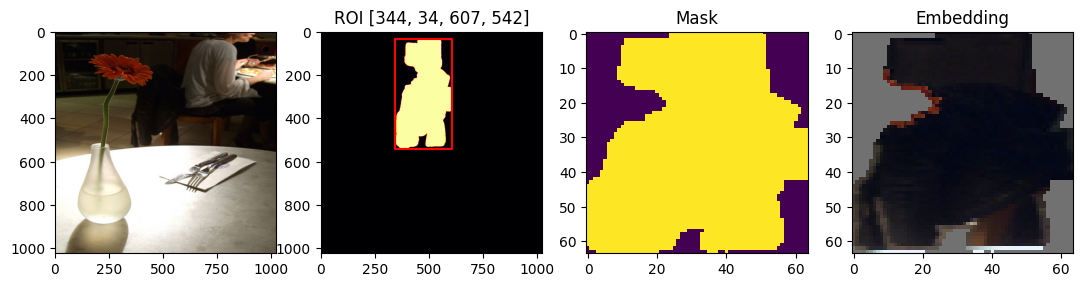

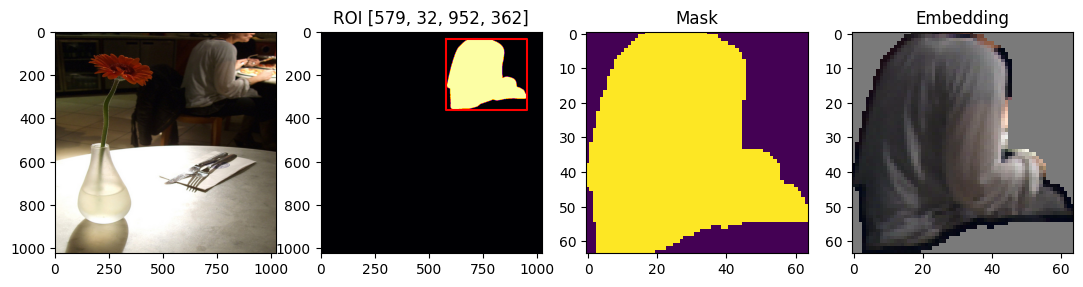

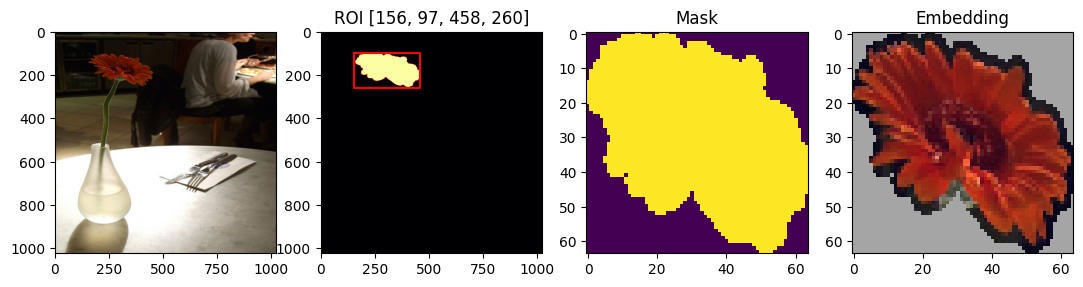

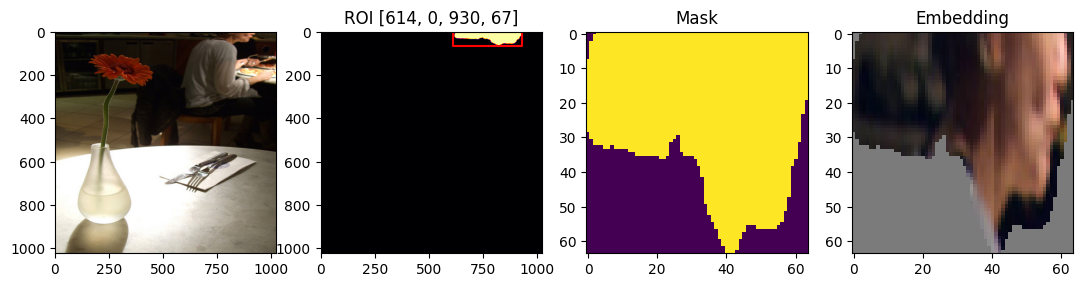

<Figure size 1500x1500 with 0 Axes>

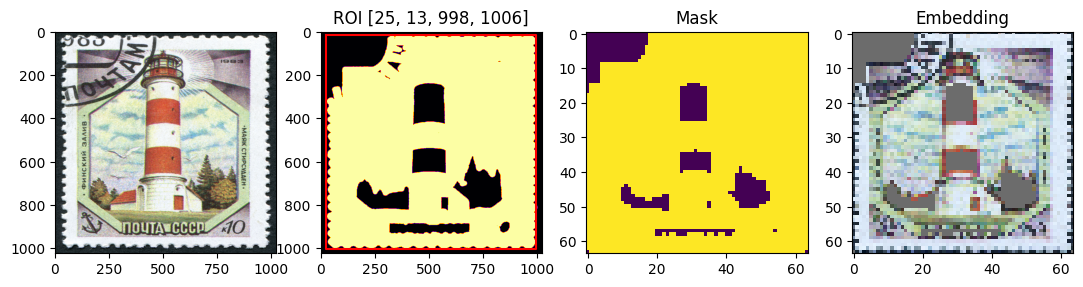

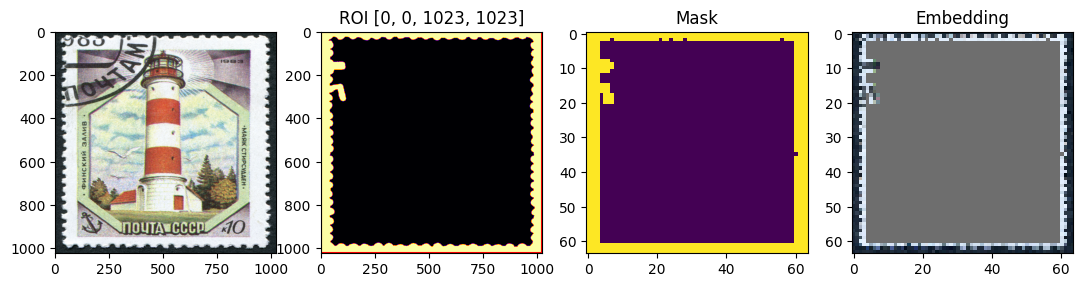

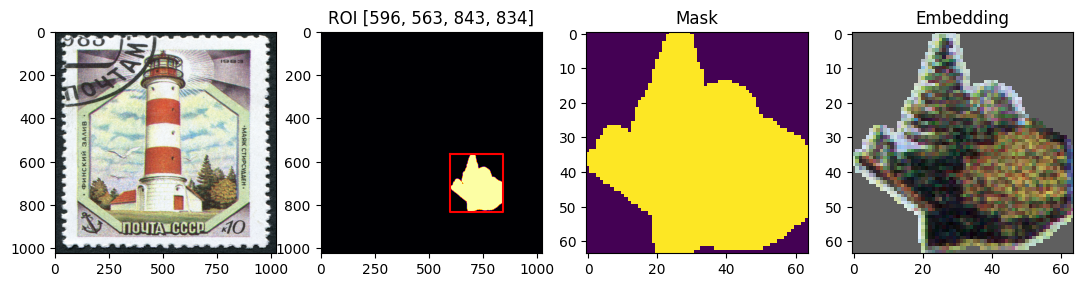

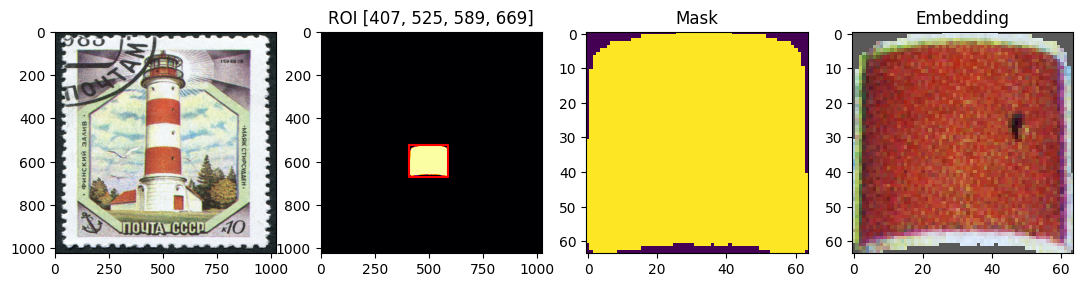

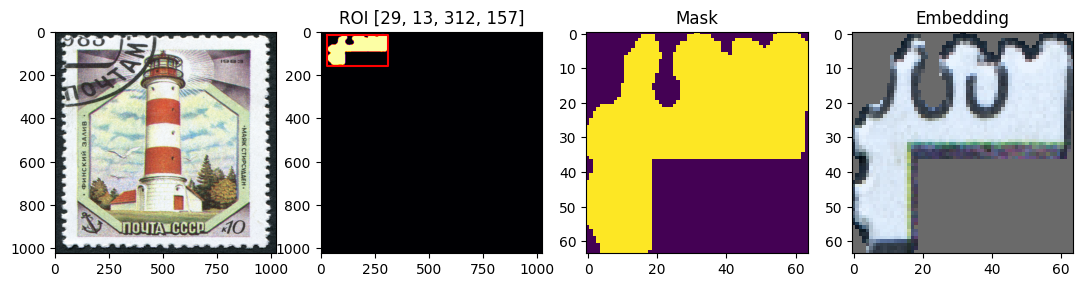

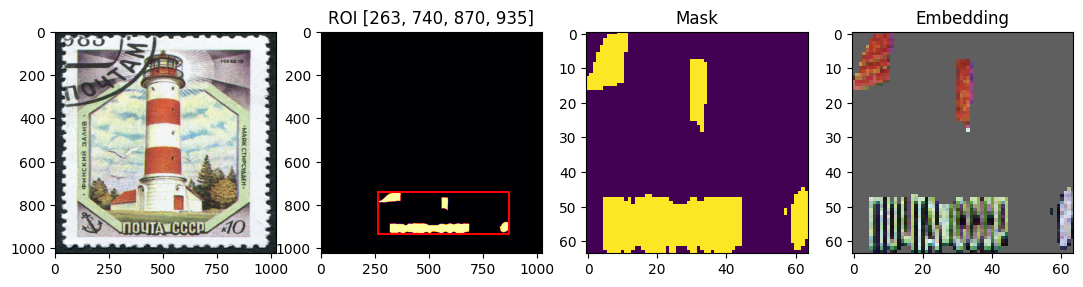

: 

In [9]:
C = visual_token_embedding.vision_encoder.feature_channels
token_resolution = visual_token_embedding.config.token_resolution

for b, image in enumerate(images):

    plt.figure(figsize=(15, 15))
    n_rows = 6
    n_cols = 6

    # for i in range(n_rows * n_cols):
    #     plt.subplot(n_rows, n_cols, i + 1)
    #     plt.imshow(batch_masks_cpu[0][i])
    #     plt.axis('off')
    #     plt.title(batch_masks_cpu[0][i].sum())
        
    image = image.resize((image_resolution, image_resolution))
    down_sample_ratio = image_resolution // 1
    for i in range(6):
        plt.figure(figsize=(20, 8))
        plt.subplot(1, 6, 1)
        plt.imshow(image)

        plt.subplot(1, 6, 2)
        plt.imshow(batch_masks_cpu[b, i], cmap='inferno')

        x1, y1, x2, y2 = (roi_boxes[b][i] * down_sample_ratio).astype(int)
        plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'r')
        plt.title(f'ROI [{x1}, {y1}, {x2}, {y2}]')

        plt.subplot(1, 6, 3)
        plt.title('Mask')
        plt.imshow(roi_masks[b][i])

        plt.subplot(1, 6, 4)
        plt.title('Embedding')
        embedding = embeddings[b][i]
        embedding = embedding.reshape(C, token_resolution, token_resolution)

        # unsqueeze embedding
        embedding = np.expand_dims(embedding, axis=0)
        plt.imshow(apply_pca(embedding)[0])
        # plt.imshow(feature_maps_rgb * roi_masks[b][i][:, :, None])

        plt.show()
